# Домашнее задание
Дообучение энкодерных моделей

**Цель:**

В этом задании вы поработаете с энкодерными трансформерными моделями (например, BERT) и дообучите их для решения различных задач обработки естественного языка (NLP).

**Описание / пошаговая инструкция выполнения домашнего задания:**


1. **Обработка данных:**

- В дополнительных материалах к уроку найдите датасет с отзывами о ресторанах (restaurants_reviews.jsonl).
- Разбейте данные на train/val/test, отложив по 15% в test и val. Не забудьте зафиксировать random_state. В качестве целевой переменной возьмите общий отзыв из колонки general.
- Оставьте только отзывы с рейтингом general равным 1, 3 и 5. Для удобства перекодируйте лейблы 1, 3 и 5 в метки 0, 1, 2.


2. **Дообучение энкодерных моделей:**

- Возьмите 3 модели:

    - https://huggingface.co/sberbank-ai/ruBert-base/ или https://huggingface.co/sberbank-ai/ruBert-large/
    - https://huggingface.co/cointegrated/rubert-tiny2
    - https://huggingface.co/google-bert/bert-base-multilingual-cased

- Дообучите каждую модель на train части данных. Обучение прекращайте, когда модель выходит на плато по метрике на валидации.
- Возьмите итоговый чекпоинт (версию, с минимальным loss на валидации) и замерьте качество на test. В качестве метрики используйте accuracy.


3. **Анализ результатов:**

- Составьте таблицу с результатами для каждой модели, включающую:

    - количество эпох до достижения минимального значения loss на валидационной выборке;
    - время, затрачиваемое на одну итерацию обучения;
    - общее время дообучения;

- Проведите анализ полученных результатов и опишите выводы в Markdown в ноутбуке.


In [ ]:
import gc, time
import pandas as pd
pd.options.display.max_colwidth = 300
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from torch.optim import Adam
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#1. Обработка данных

##1.1.Загрузка данных: датасет с отзывами о ресторанах (restaurants_reviews.jsonl)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_json('./restaurants_reviews.jsonl', lines=True)
df = pd.read_json('/content/drive/MyDrive/restaurants_reviews.jsonl', lines=True)
df[20:25]

,review_id,general,food,interior,service,text
20,20,0,10,10,10,"Отличный ресторан ! Отмечали свадьбу 25.02.2013 . Долго выбирали зал и очень рады , что остановились именно здесь ! Красиво , уютно , светло и с комфортом . Мы выбрали большой зал , т. к. нас было около 80 человек . Зал большой , просторный . В числе приглашенных было много семей с детьми ..."
21,21,0,7,7,5,"Продолжая свой рейд по курортному побережью поехала в Шелест , скажу честно , слышала несколько позитивных отзывов от знакомых и уважаемых людей . Была в субботу 30 марта , гостей много , встретили хорошо . Далее сервис - жестко , просто жестко . Делая скидку на несезон все равно плохо . Для..."
22,22,0,10,10,10,"Хороший ресторан , были два раза и оба раза остались довольны !! все блюда вкусно и качественно приготовлены , обслуживание на высоте !! Огромное и отдельное спасибо за десерты , особенно "" шоколадный фан-дан "" - это просто восхитительно !!!!"
23,23,0,10,10,10,"Приятный персонал ресторана . Вкусная кухня . Великолепные десерты . Уютная атмосфера . Несколько раз выключалось электричество , но это был не форс-мажор , а романтическая изюминка .. зажженные свечи .. Наслаждение приятным комплиментом ( извинение за доставленное неудобство ) . Далее горя..."
24,24,0,6,2,1,"Да чтобы я еще раз туда пришла ! С подругами решили устроить небольшой девичник дома , и после захотелось потанцевать . Выбирали по месторасположению и оценкам - нашли Шампань . Сразу скажу - более противного , ужасающего места я не встречала . Контингент этого заведения просто ниже плинтуса..."


##1.2.Оставляем только отзывы с рейтингом "general" равным 1, 3 и 5, используем булевую маску (True/False), True для строк, где general равен 1, 3 или 5

In [ ]:
df = df[df['general'].isin([1,3,5])] # перезапишем df, оставляя только строки с general равным 1, 3 или 5.
df['general'].value_counts() # посмотрим распределение

,count
general,
5,2164
1,462
3,150


## 1.3.Перекодируем лейблы 1, 3 и 5 в метки 0, 1, 2.

In [ ]:
rating_map = {1:0, 3:1, 5:2}
df['general'] = df['general'].map(rating_map)

In [ ]:
df['general'].value_counts()

,count
general,
2,2164
0,462
1,150


##1.4.Разбиваем данные на train/val/test, отложив по 15% в test и val. В качестве целевой переменной берем общий отзыв из колонки general.

In [ ]:
# Создаём объект Dataset из библиотеки Hugging Face datasets на основе DataFrame df
dataset_f = Dataset.from_dict({'text': df.text, 'label': df.general}) # целевая переменная - "general" (Y)
dataset_f

Dataset({
    features: ['text', 'label'],
    num_rows: 2776
})

In [ ]:
# Первичное разделение на обучающую + валидационную (85%) и тестовую (15%) части
train_test_split = dataset_f.train_test_split(test_size=0.15, seed=42)  # Указываем seed для воспроизводимости
train_val_split = train_test_split["train"]  # Временный набор для дальнейшего деления
test_dataset = train_test_split["test"]

In [ ]:
# Вторичное разделение на финальные обучающую (70%) и валидационную (15%) части
# Размер валидации: 0.15 / 0.85 ≈ 0.1765 от оставшихся данных
final_split = train_val_split.train_test_split(test_size=0.1765, seed=42)
train_dataset = final_split["train"]
val_dataset = final_split["test"]

In [ ]:
print("Размеры после разделения средствами datasets:")
print(f"  Обучающая выборка (train): {len(train_dataset)} примеров")
print(f"  Валидационная выборка (validation): {len(val_dataset)} примеров")
print(f"  Тестовая выборка (test): {len(test_dataset)} примеров")

Размеры после разделения средствами datasets:
  Обучающая выборка (train): 1942 примеров
  Валидационная выборка (validation): 417 примеров
  Тестовая выборка (test): 417 примеров


In [ ]:
# Создаем удобный словарь датасетов
data = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

In [ ]:
# Чистим память
del dataset_f, train_test_split, train_val_split, final_split

In [ ]:
data['train'][2]

{'text': 'Хочу поблагодарить коллектив банкетного зала Диора за хороший отдых и замечательную кухню .  Мы отмечаем совместные праздники своей компанией в этом зале уже 2 года .  Сам по себе " стаж " говорит о многом .  Нам нравится , что мы можем за приемлемую сумму прекрасно отдохнуть , потанцевать , вкусно поесть .  Независимо от суммы заказа , всегда красиво оформляется стол , персонал замечательный .  Мы ходим сами и рекомендуем друзьям .  Все остаются довольны .  Спасибо !  ',
 'label': 2}

# 2. Дообучение энкодерных моделей

    - https://huggingface.co/sberbank-ai/ruBert-base/
    - https://huggingface.co/cointegrated/rubert-tiny2
    - https://huggingface.co/google-bert/bert-base-multilingual-cased

## 2.1 ruBERT-base

In [ ]:
#Загрузка модели
b_base_model = 'ai-forever/ruBert-base'

In [ ]:
#Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(b_base_model)
tokenizer

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

BertTokenizerFast(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
#Подготовка текстовых данных для моделей трансформеров.Токенизация текстовых данных с помощью библиотеки Transformers
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1942 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1942
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [ ]:
#Убедимся, что токенизация работает правильно: выведем третий элемент из тренировочной части токенизированного датасета
print(data_tokenized['train'][2])

{'label': 2, 'input_ids': [101, 3371, 32821, 18677, 61617, 747, 11557, 39883, 649, 681, 32326, 378, 17803, 107, 85363, 15121, 126, 945, 104094, 30350, 24528, 2467, 378, 1410, 863, 378, 113, 1019, 7132, 965, 149, 878, 126, 1765, 654, 1494, 152, 48321, 152, 2531, 104, 11423, 126, 1671, 5565, 121, 693, 945, 5234, 681, 22541, 4351, 6171, 6133, 17461, 121, 113405, 121, 33167, 30439, 126, 13996, 700, 11459, 14987, 121, 1928, 15643, 119553, 2585, 121, 24808, 4077, 14555, 378, 126, 945, 75532, 2565, 107, 55177, 18513, 126, 780, 10543, 24800, 126, 7953, 177, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# Cоздаём объект DataCollatorWithPadding для автоматического дополнения (padding) батчей данных до одинаковой длины.
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
#Создаём три DataLoader'а (для загруки данных батчами, их автоматического перемешивания и коллатора)для обучения, валидации и тестирования модели
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=8, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=8, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=8, collate_fn=collator)

In [ ]:
#Создаём модель для классификации последовательностей текста на основе предобученной модели
model = AutoModelForSequenceClassification.from_pretrained(b_base_model, num_labels=3)
model

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
#Перемещаем модель на выбранное вычислительное устройство (GPU или CPU)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-6)  #малая скорость обучения и след. меньше риск "перепрыгнуть" оптимум
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#Полный цикл обучения нейронной сети с сохранением лучшей модели
best_eval_loss = float('inf') #начальное значение для поиска минимума

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #сохраняем лучшую модель
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.5275960884988308 Eval Loss 0.44811940080714674 Accuracy 0.8225419664268585 Time: 124.18433570861816


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.31861973375082014 Eval Loss 0.3340441678773682 Accuracy 0.9040767386091128 Time: 255.2413673400879


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.2685766952484846 Eval Loss 0.30231565279218386 Accuracy 0.9232613908872902 Time: 393.8416771888733


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.2742079973220825 Eval Loss 0.2936578537776785 Accuracy 0.9280575539568345 Time: 536.2718226909637


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.24361454047262668 Eval Loss 0.29676159759456255 Accuracy 0.9232613908872902 Time: 678.7788128852844


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.24786319540813564 Eval Loss 0.2980150769482244 Accuracy 0.9232613908872902 Time: 802.1820111274719


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.20737875821068882 Eval Loss 0.302731672091023 Accuracy 0.9184652278177458 Time: 925.7415354251862


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.17290565667673946 Eval Loss 0.2952844038043382 Accuracy 0.920863309352518 Time: 1048.7075054645538


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.18260630013421178 Eval Loss 0.31747621561418166 Accuracy 0.9184652278177458 Time: 1170.5760474205017


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.18690704135224223 Eval Loss 0.302102989903739 Accuracy 0.9112709832134293 Time: 1293.8964672088623


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.1750397309474647 Eval Loss 0.30607233614713514 Accuracy 0.9136690647482014 Time: 1416.3293240070343


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.1719642617367208 Eval Loss 0.29383713040360304 Accuracy 0.9112709832134293 Time: 1540.1888439655304


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.14556755679659544 Eval Loss 0.3028811449887899 Accuracy 0.9160671462829736 Time: 1662.9163897037506


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.11823222027160227 Eval Loss 0.3067753201807445 Accuracy 0.9160671462829736 Time: 1786.7530343532562


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.15858018030412496 Eval Loss 0.34746194885657083 Accuracy 0.9016786570743405 Time: 1911.7017402648926


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.10331919938325881 Eval Loss 0.31118504281313913 Accuracy 0.9160671462829736 Time: 2036.5714266300201


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.0987358068395406 Eval Loss 0.31676869444057065 Accuracy 0.9184652278177458 Time: 2161.3858938217163


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.11283961146138609 Eval Loss 0.327959486160357 Accuracy 0.9136690647482014 Time: 2285.479517221451


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.07885822279378772 Eval Loss 0.34312087573321925 Accuracy 0.9088729016786571 Time: 2409.9971375465393


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.10266279749572277 Eval Loss 0.3292641446240387 Accuracy 0.9112709832134293 Time: 2533.607257127762


In [ ]:
#Находим индекс (номер) лучшей эпохи обучения и соответствующую минимальную ошибку валидации
epoch_eval_loss.index(min(epoch_eval_loss)), min(epoch_eval_loss)

(3, np.float64(0.2936578537776785))

In [ ]:
#Находим общее время обучения до лучшей эпохи (эпохи с минимальной ошибкой валидации)
epoch_train_time[epoch_eval_loss.index(min(epoch_eval_loss))]

536.2718226909637

In [ ]:
epoch_train_time[-1]

2533.607257127762

In [ ]:
#вычисление среднего времени обучения на одну эпоху
epoch_train_time[-1]/len(epoch_train_time)

126.68036285638809

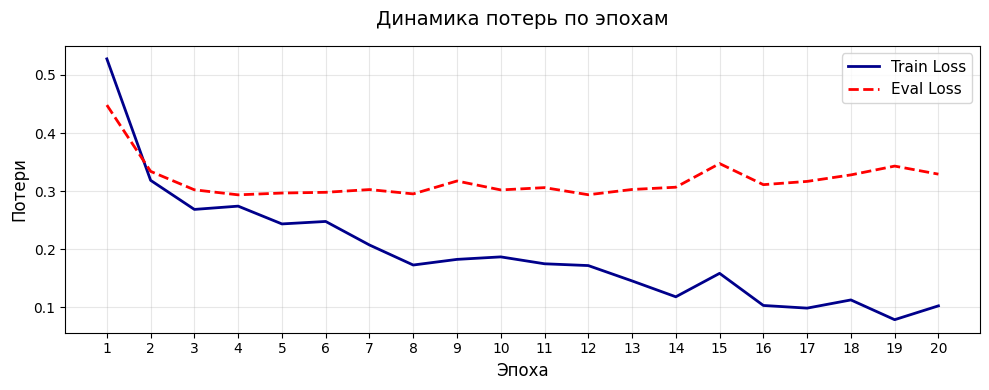

In [ ]:
# Построение графика потерь на обучающей и валидационной выборках
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, color='darkblue', linewidth=2, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, color='red', linewidth=2, label='Eval Loss', linestyle='--')

plt.xticks(np.arange(1, 21, 1))
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Потери', fontsize=12)
plt.title('Динамика потерь по эпохам', fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()  # Автоматическая подгонка отступов
plt.show()

##Загрузим лучшую сохраненную модель

In [ ]:
#Загрузка лучшей сохраненной модели
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
#Выполняем оценку модели на тестовом наборе данных.
model.eval()
test_losses = []
test_preds = []
test_targets = []

for batch in tqdm(test_dataloader):
    with torch.no_grad():
            out = model(**batch.to(model.device))
    test_losses.append(out.loss.item())
    test_preds.extend(out.logits.argmax(1).tolist())
    test_targets.extend(batch['labels'].tolist())

print('Eval Loss', np.mean(test_losses), 'Accuracy', np.mean(np.array(test_targets) == test_preds))

  0%|          | 0/53 [00:00<?, ?it/s]

Eval Loss 0.30242440301292345 Accuracy 0.9040767386091128


In [ ]:
accuracy_score(test_targets, test_preds)

0.9040767386091128

In [ ]:
confusion_matrix(test_targets, test_preds)

array([[ 71,   0,   4],
       [ 16,   0,   6],
       [ 14,   0, 306]])

## Оценка модели

In [ ]:
results = {}

In [ ]:
def quality(etime, vloss):
    """
        etime: списокаккумулированного времени train для каждой эпохи;
        vloss: список validation losses для каждой эпохи;
    """
    # количество эпох до достижения минимального значения loss на валидационной выборке,
    min_epoch_num = vloss.index(min(vloss))
    #общее время дообучения
    total_train_time = etime[min_epoch_num]
    #время, затрачиваемое на одну итерацию обучения
    avg_train_step_time = etime[-1]/len(etime)
    print(f"min_epoch_num: {min_epoch_num+1}, avg_train_step_time: {avg_train_step_time}, total_train_time: {total_train_time} ")
    return [min_epoch_num+1, round(avg_train_step_time, 2), round(total_train_time, 2)]

In [ ]:
def get_model_results(etime, vloss, dataloader, model):
    """
        dataloader: Dataloader для  модели;
        model: Model для test;
    """
    # количество эпох до достижения минимального значения loss на валидационной выборке,
    min_epoch_num = vloss.index(min(vloss))
    #общее время дообучения
    total_train_time = etime[min_epoch_num]
    #время, затрачиваемое на одну итерацию обучения
    avg_train_step_time = etime[-1]/len(etime)

    model.eval()
    test_losses = []
    test_preds = []
    test_targets = []

    for batch in tqdm(test_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        test_losses.append(out.loss.item())
        test_preds.extend(out.logits.argmax(1).tolist())
        test_targets.extend(batch['labels'].tolist())

    accuracy_metric = np.mean(np.array(test_targets) == test_preds)

    print(f"min_epoch: {min_epoch_num+1}, epoch_time: {avg_train_step_time}, total_train_time: {total_train_time}, accuracy: {accuracy_metric}")
    return [min_epoch_num+1, round(avg_train_step_time, 2), round(total_train_time, 2), round(accuracy_metric,4)]

In [ ]:
quality(epoch_train_time, epoch_eval_loss)

min_epoch_num: 4, avg_train_step_time: 126.68036285638809, total_train_time: 536.2718226909637 


[4, 126.68, 536.27]

In [ ]:
get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 4, epoch_time: 126.68036285638809, total_train_time: 536.2718226909637, accuracy: 0.9040767386091128


[4, 126.68, 536.27, np.float64(0.9041)]

Сохраним результаты

In [ ]:
results['ruBERT-base'] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 4, epoch_time: 126.68036285638809, total_train_time: 536.2718226909637, accuracy: 0.9040767386091128


In [ ]:
pd.DataFrame(results, index=['Epoch num','Epoch avg time','Total train time','Accuracy']).T

,Epoch num,Epoch avg time,Total train time,Accuracy
ruBERT-base,4.0,126.68,536.27,0.9041


## 2.2 ruBERT-tiny2

In [ ]:
b_base_model = 'cointegrated/rubert-tiny2'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(b_base_model)
tokenizer

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1942 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1942
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [ ]:
print(data_tokenized['train'][2])

{'label': 2, 'input_ids': [2, 35034, 52180, 30140, 74439, 1211, 26478, 50493, 1232, 650, 32000, 34321, 320, 35012, 35389, 47118, 18, 19712, 29900, 44628, 48658, 36530, 4182, 18026, 314, 3200, 32911, 3687, 22, 735, 18, 16194, 705, 4404, 6, 34193, 6, 16667, 326, 32869, 18, 32130, 31142, 16, 1046, 11521, 30872, 650, 39581, 3236, 30678, 31788, 38867, 16, 66598, 18673, 4963, 16, 50505, 60719, 18, 43025, 733, 33099, 37379, 16, 13157, 32579, 76555, 30881, 16, 39149, 49694, 18, 19712, 28527, 2639, 22704, 320, 49245, 40821, 18, 9057, 31885, 48309, 18, 32426, 5, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=16, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=16, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=16, collate_fn=collator)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(b_base_model, num_labels=3)
model

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-5)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
best_eval_loss = float('inf')

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #сохранение лучшей модели
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.7216806355118751 Eval Loss 0.5918586828090526 Accuracy 0.7913669064748201 Time: 11.127290725708008


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.5254416674375534 Eval Loss 0.4619348998422976 Accuracy 0.86810551558753 Time: 22.677619457244873


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.38564027078449725 Eval Loss 0.36080397223984756 Accuracy 0.8992805755395683 Time: 34.07223439216614


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.3292655300348997 Eval Loss 0.3305028249268179 Accuracy 0.9064748201438849 Time: 45.83387851715088


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.2891474480554461 Eval Loss 0.3340821714588889 Accuracy 0.8992805755395683 Time: 57.28183841705322


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.2641888380423188 Eval Loss 0.32780217641481646 Accuracy 0.9064748201438849 Time: 69.69851183891296


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.24965014919638634 Eval Loss 0.3343179283870591 Accuracy 0.9112709832134293 Time: 81.54639744758606


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.23290691567584873 Eval Loss 0.33494983744566087 Accuracy 0.9112709832134293 Time: 92.90087723731995


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.21173872768878937 Eval Loss 0.34029348353268923 Accuracy 0.9112709832134293 Time: 104.08726096153259


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.18989601489156485 Eval Loss 0.350974233545087 Accuracy 0.9112709832134293 Time: 115.46383714675903


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.18335218099877237 Eval Loss 0.3570813196538775 Accuracy 0.9088729016786571 Time: 126.7601592540741


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.16718162063509226 Eval Loss 0.3657732969494881 Accuracy 0.9016786570743405 Time: 138.1065707206726


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.15404169857501984 Eval Loss 0.37711767886799796 Accuracy 0.9040767386091128 Time: 149.48157000541687


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.15090194972231985 Eval Loss 0.3827228439902818 Accuracy 0.8896882494004796 Time: 160.87017703056335


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.12961346592754125 Eval Loss 0.39786131576531464 Accuracy 0.8800959232613909 Time: 174.36984157562256


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.1234188737347722 Eval Loss 0.40952160326695003 Accuracy 0.882494004796163 Time: 185.76877284049988


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.1082975017465651 Eval Loss 0.4126377065355579 Accuracy 0.8800959232613909 Time: 196.9965693950653


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.09732372977770865 Eval Loss 0.4446904911763138 Accuracy 0.8800959232613909 Time: 209.88226747512817


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.0817983715236187 Eval Loss 0.43166471345143187 Accuracy 0.8729016786570744 Time: 221.13533353805542


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.07508322489447891 Eval Loss 0.44456139030969805 Accuracy 0.8848920863309353 Time: 232.5515275001526


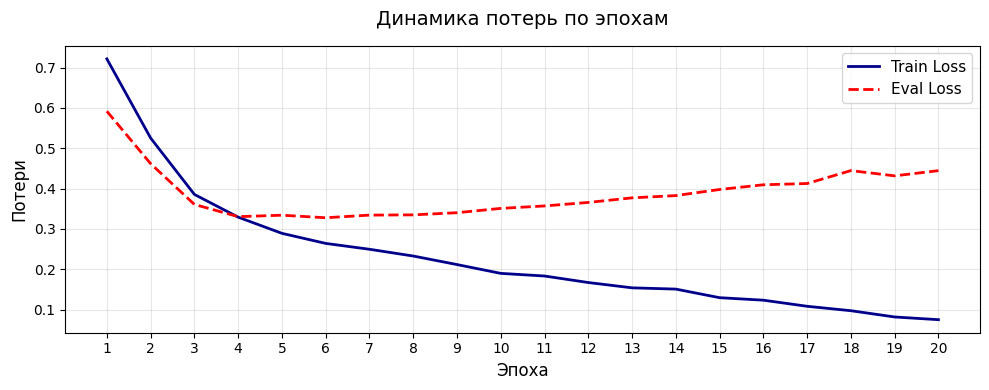

In [ ]:
# Построение графика потерь на обучающей и валидационной выборках
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, color='darkblue', linewidth=2, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, color='red', linewidth=2, label='Eval Loss', linestyle='--')
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Потери', fontsize=12)
plt.title('Динамика потерь по эпохам', fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()  # Автоматическая подгонка отступов
plt.show()

##Загрузим лучшую сохраненную модель

In [ ]:
#loading the best saved model
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
path

'rubert-tiny2.saved.weights.pt'

In [ ]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

### Протестируем и сохраним результаты

In [ ]:
get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/27 [00:00<?, ?it/s]

min_epoch: 6, epoch_time: 11.62757637500763, total_train_time: 69.69851183891296, accuracy: 0.8800959232613909


[6, 11.63, 69.7, np.float64(0.8801)]

In [ ]:
results['ruBERT-tiny2'] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/27 [00:00<?, ?it/s]

min_epoch: 6, epoch_time: 11.62757637500763, total_train_time: 69.69851183891296, accuracy: 0.8800959232613909


## 3. Анализ результатов

Расчет модели bert-base-multilingual-cased не был выполнен из-за того, что закончились вычислительные ресурсы. Но это не мешает сделать итоговые выводы.

In [ ]:
pd.DataFrame(results, index = ['Epoch num','Epoch avg time','Total train time','Accuracy']).T.sort_values(by=['Accuracy'], ascending=False)

,Epoch num,Epoch avg time,Total train time,Accuracy
ruBERT-base,4.0,126.68,536.27,0.9041
ruBERT-tiny2,6.0,11.63,69.70,0.8801


**Вывод:**

между моделями наблюдается компромисс между точностью и скоростью. Выбор лучшей модели будет зависеть от конкретных целей проекта.

**Точность:**

- ruBert-base точнее (0.90). Разница в 2% в классификации бывает важной и может оправдать использование более тяжелой модели (670 МБ).
- rubert-tiny2 показывает отличный результат для своего класса (точность =0.88, размер модели около 125МБ). Уступая всего 2%, она показывает высокую эффективность архитектуры, адаптированной для русского языка.

**Скорость и эффективность обучения**

Здесь преимущество rubert-tiny2 абсолютно очевидно:

- Время эпохи меньше в ~11.5 раз (12 сек. против 127 сек.). Это позволяет гораздо быстрее проводить эксперименты, отлаживать код и перебирать гиперпараметры.
- Общее время обучения меньше в ~7,7 раз (70 сек. против 536 сек.). Tiny2 достигла плато за большее число эпох, но благодаря скорости каждой эпохи обучилась значительно быстрее.
- ruBert-base достигла плато быстрее (за 4 эпохи), но цена каждой эпохи очень высока.

Для предварительных расчетов в Google Colab я выбрала бы модель tiny2